### Complejidad - Práctico 6 - Criticalidad auto organizada en crashes financieros
#### Lautaro Giordano
En este trabajo voy a explorar la aparición de criticalidad en series temporales de precios de instrumentos financieros y criptomonedas. Las "avalanchas" en este caso serían la fluctuaciones del precio en un período muy corto de tiempo, dado por mucha gente que sin haberse puesto de acuerdo decide comprar o vender estos activos en masa en un período muy corto de tiempo (que se conocen como crashes). Estos crashes o avalanchas tienen magnitudes distintas, y pueden ser generados o aunque sea influenciados por factores diversos como el estallido de una guerra, la imposición de sanciones económicas o impuestos, resultados de elecciones, acciones con sobreprecio que terminan en la explosión de una burbuja, etc. En lo que sigue voy a trabajar con dos instrumentos muy distintos: el índice S&P500 (como un MERVAL pero de las 500 empresas más importantes de estados unidos), y ya que estamos, voy a usar el precio del bitcoin, que tiene una volatibilidad mucho mayor. Me voy a basar en el trabajo de [Bartolozzi et. al. (2004)](https://arxiv.org/abs/cond-mat/0405257) para tratar de replicar sus métodos y comparar resultados.

In [81]:
import numpy as np
from matplotlib import pyplot as plt
# yfinance es la libreria de yahoo finance que tiene datos historicos de acciones
import yfinance as yf
# La librería PyWavelets es para hacer la transformada wavelet de los datos
import pywt
from scipy import stats
import pandas as pd

In [82]:
# Descarga los datos históricos del S&P 500
ticker = "^GSPC"  # Símbolo del S&P 500 en Yahoo Finance
sp500 = yf.download(ticker, start='1960-01-01', end=None, interval="1d")

# Mostrar las primeras filas de los datos
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
1960-01-04 00:00:00+00:00,59.910000,59.910000,59.910000,59.910000,59.910000,3990000
1960-01-05 00:00:00+00:00,60.389999,60.389999,60.389999,60.389999,60.389999,3710000
1960-01-06 00:00:00+00:00,60.130001,60.130001,60.130001,60.130001,60.130001,3730000
1960-01-07 00:00:00+00:00,59.689999,59.689999,59.689999,59.689999,59.689999,3310000
1960-01-08 00:00:00+00:00,59.500000,59.500000,59.500000,59.500000,59.500000,3290000


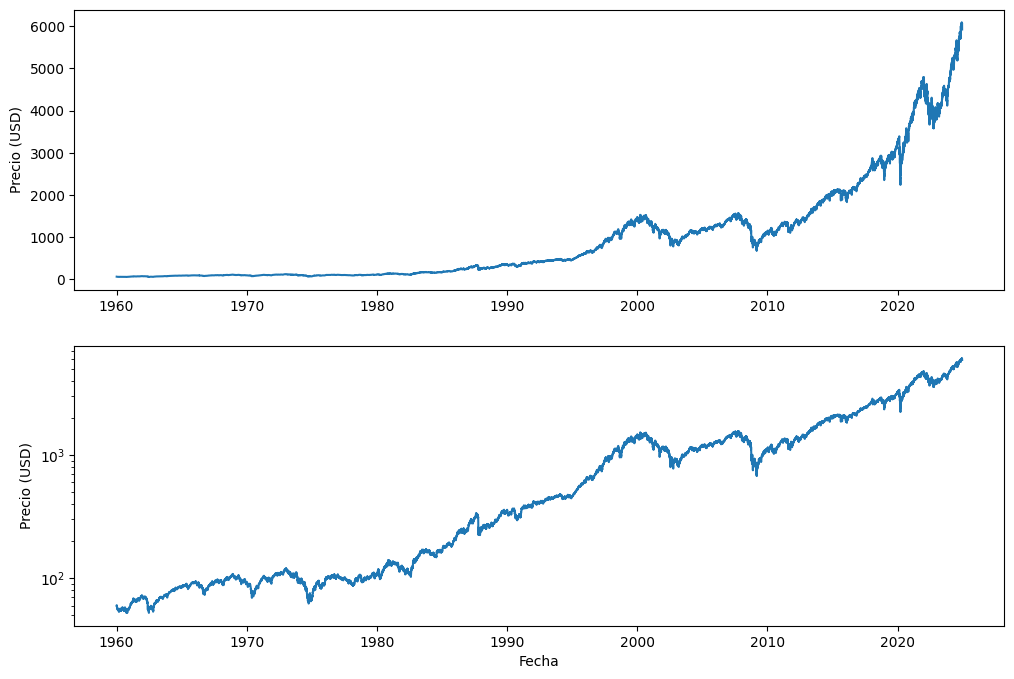

In [83]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Adj Close es el precio de cierre.
ax1.plot(sp500["Adj Close"])
ax2.plot(sp500["Adj Close"])
ax1.set_ylabel("Precio (USD)")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Precio (USD)")
ax2.set_yscale("log")

Existen ciertos eventos donde el cambio de precio relativo es muy alto en un período de tiempo muy corto, esos son los crashes. Veamos los más importantes más de cerca.

Text(0, 0.5, 'Precio (USD)')

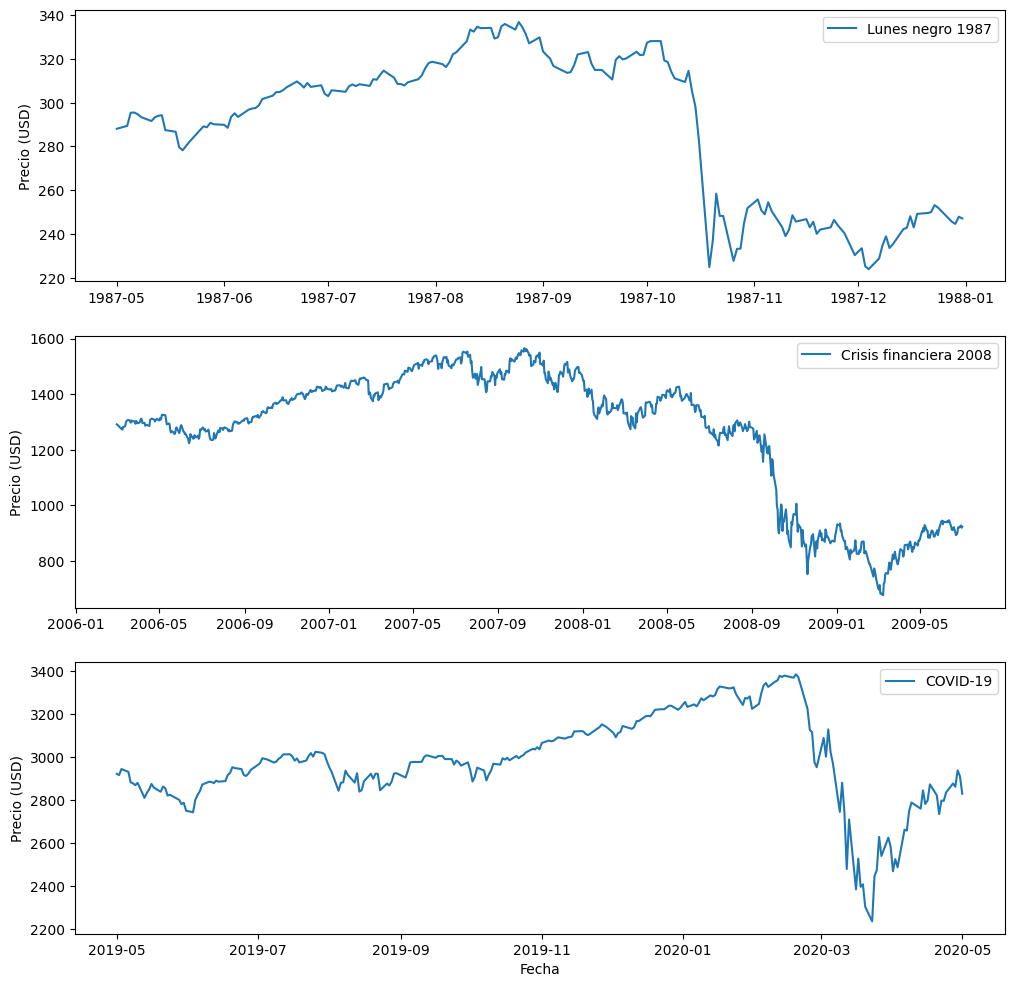

In [84]:
# Muestro los crashes de 1987, 2008 y 2020
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
ax1.plot(sp500["Adj Close"]["1987-05-01":"1988-01-01"], label="Lunes negro 1987")
ax2.plot(sp500["Adj Close"]["2006-03-01":"2009-07-01"], label="Crisis financiera 2008")
ax3.plot(sp500["Adj Close"]["2019-05-01":"2020-05-01"], label="COVID-19")
ax1.legend()
ax2.legend()
ax3.legend()
ax3.set_xlabel("Fecha")
ax1.set_ylabel("Precio (USD)")
ax2.set_ylabel("Precio (USD)")
ax3.set_ylabel("Precio (USD)")

Estos gráficos nos sirven para ver que no solo la magnitud es variable, sino también la escala temporal en la que suceden estos crashes. Por ejemplo, la crisis financiera del 2008 persistió por meses a poco más de un año, donde la acción cayó alrededor de un $50%$, mientras que en el lunes negro los mercados financieros tuvieron una caída de alredor del $26%$ en un único día.

En lo que sigue vamos a calcular los retornos del precio del instrumento cada día. En finanzas (y en el paper que estoy siguiendo) se usa el log-returns $log(p_{t+1} / p_{t}$), pero también voy a mostrar los retornos relativos $(p_{t+1} - p_t) / p_t$ para que se vea que son muy parecidos ($log(x) \approx x - 1$). En lo que sigue solo voy a trabajar con log-returns

In [85]:
# Calcular los retornos logarítmicos
sp500['Log Return'] = np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(1))

# Y si no usamos el log return y solo la diferencia relativa de precios?
sp500['Return'] = (sp500['Adj Close'] - sp500['Adj Close'].shift(1)) / sp500['Adj Close'].shift(1)

# Eliminar valores NaN resultantes del desplazamiento
sp500.dropna(inplace=True)

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_7108\698500811.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


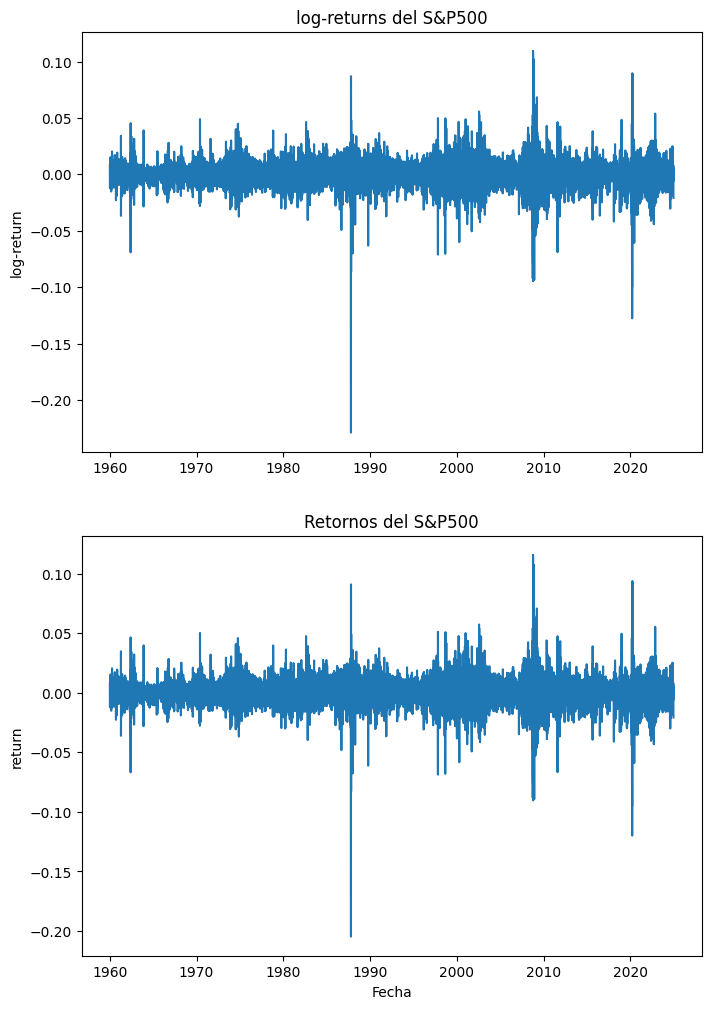

In [86]:
# Graficar los retornos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.plot(sp500['Log Return'])
ax1.set_ylabel('log-return')
ax1.set_title('log-returns del S&P500')

ax2.plot(sp500['Return'])
ax2.set_title('Retornos del S&P500')
ax2.set_ylabel('return')
ax2.set_xlabel('Fecha')
fig.show()

Veamos como es el histograma de los retornos (centrado y normalizado), para compararlo con una gaussiana

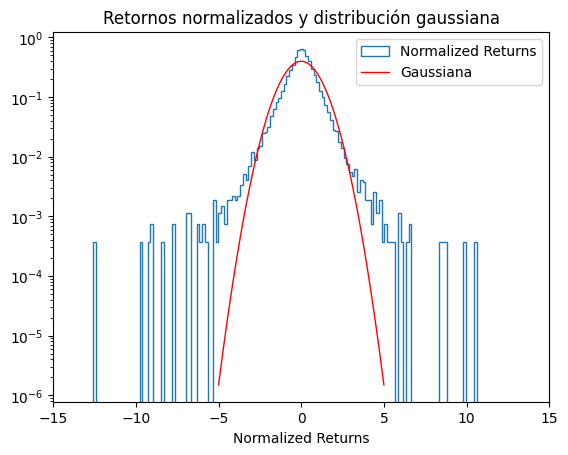

In [87]:
normalized_returns = sp500['Log Return'].values
mean = np.mean(normalized_returns)
std = np.std(normalized_returns)
normalized_returns = (normalized_returns - mean) / std

# Graficar los retornos normalizados
plt.hist(normalized_returns, bins=200, density=True, histtype='step', label='Normalized Returns')
plt.xlabel('Normalized Returns')

# Gaussiana
x = np.linspace(-5, 5, 1000)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, 'r', linewidth=1, label='Gaussiana')
plt.legend()
plt.xlim(-15, 15)
plt.yscale('log')
plt.title("Retornos normalizados y distribución gaussiana")
plt.show()

Vemos que aparecen más extremos eventos que los esperados en una distribución gaussiana (la cola de la distribución es más pesada).

Cómo se ve la distribución del valor absoluto de los retornos? Es libre de escala?

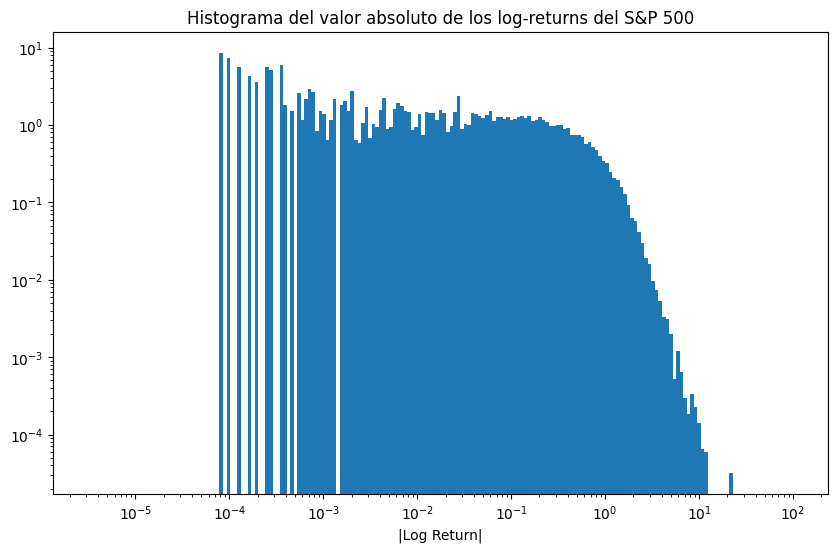

In [88]:
# Histograma de los retornos absolutos
plt.figure(figsize=(10, 6))

bins = np.logspace(-5.5, 2, 200)

# plt.hist(np.abs(sp500['Log Return']), bins=bins, density=True)
plt.hist(np.abs(normalized_returns), bins=bins, density=True)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("|Log Return|")
plt.title("Histograma del valor absoluto de los log-returns del S&P 500")
plt.show()

No se ve una recta en un regimen de varios órdenes de magnitud. Para encontrar la criticalidad voy a tener que buscar un mecanismo para detectar las avalanchas y calcular alguna cantidad como sus volumenes.

Probando el método de Wavelet del paper de Bartolozzi

![](berto.png)

Vamos a usar una transformada wavelet discreta implementada en el paquete PyWavelets para python.

Curtosis de la serie filtrada: 581.4332706018552
Asimetría de la serie filtrada: -7.035465081544936
Curtosis del ruido: 1.9242413540618921
Asimetría del ruido: -0.16671336078583338


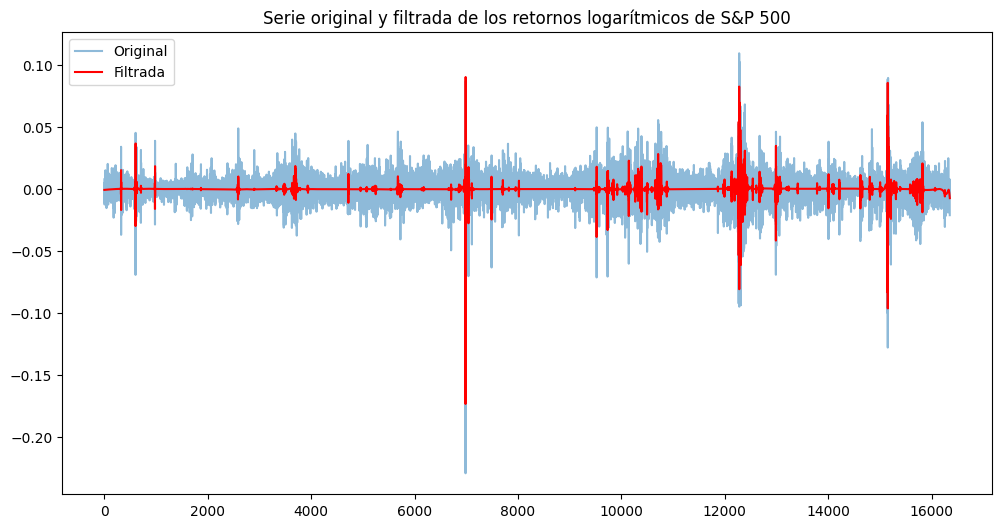

In [89]:
log_returns = sp500['Log Return'].values

# Hago la transformada wavelet de tipo Daubechies 4
wavelet = 'db4'
# coeffs es una lista de arrays, cada uno corresponde a los valores de los coeficientes 
# en distintas escalas
coeffs = pywt.wavedec(log_returns, wavelet)

# Filtro los coeficientes y me quedo solo con los más grandes (para eliminar el ruido)
cutoff = .14
threshold = cutoff * np.max(coeffs[-1]) 
filtered_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Reconstruyo la serie temporal filtrada con la transformada inversa
filtered_log_returns = pywt.waverec(filtered_coeffs, wavelet)
noise_signal = log_returns - filtered_log_returns[:len(log_returns)]

# La curtosis me da una idea de la cantidad de outliers que hay en la serie
# La asimetría me da una idea de si hay una tendencia en la serie
# Quiero ajustar el valor de cutoff para que el ruido que voy a filtrar tenga
# una curtosis y asimetría más parecidas a las de una gaussiana
print("Curtosis de la serie filtrada:", stats.kurtosis(filtered_log_returns))
print("Asimetría de la serie filtrada:", stats.skew(filtered_log_returns))
print("Curtosis del ruido:", stats.kurtosis(noise_signal))
print("Asimetría del ruido:", stats.skew(noise_signal))


plt.figure(figsize=(12, 6))
plt.plot(log_returns, label='Original', alpha=0.5)
plt.plot(filtered_log_returns, label='Filtrada', color='red')
plt.title("Serie original y filtrada de los retornos logarítmicos de S&P 500")
plt.legend()
plt.show()

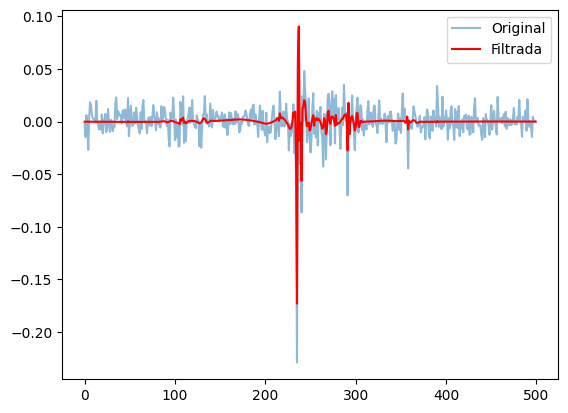

In [90]:
# Veamos un ejemplo de un pico en la serie filtrada
plt.plot(log_returns[6750:7250], label='Original', alpha=0.5)
plt.plot(filtered_log_returns[6750:7250], label='Filtrada', color='red')
plt.legend()

In [91]:
epsilon = 0.001
indices_avalanchas = np.where(np.abs(filtered_log_returns) > epsilon)[0]

# Identifico donde empieza y termina cada avalancha
avalanchas = []
inicio = indices_avalanchas[0]
for i in range(1, len(indices_avalanchas)):
    if indices_avalanchas[i] != indices_avalanchas[i - 1] + 1:
        avalanchas.append((inicio, indices_avalanchas[i - 1]))
        inicio = indices_avalanchas[i]
avalanchas.append((inicio, indices_avalanchas[-1]))  # Agrego la última avalancha

# Calculo el volumen y duracion  de cada avalancha
volumenes = []
for inicio, fin in avalanchas:
    volumen = np.sum(filtered_log_returns[inicio:fin]**2)
    volumenes.append(volumen)

duraciones = [fin - inicio + 1 for inicio, fin in avalanchas]

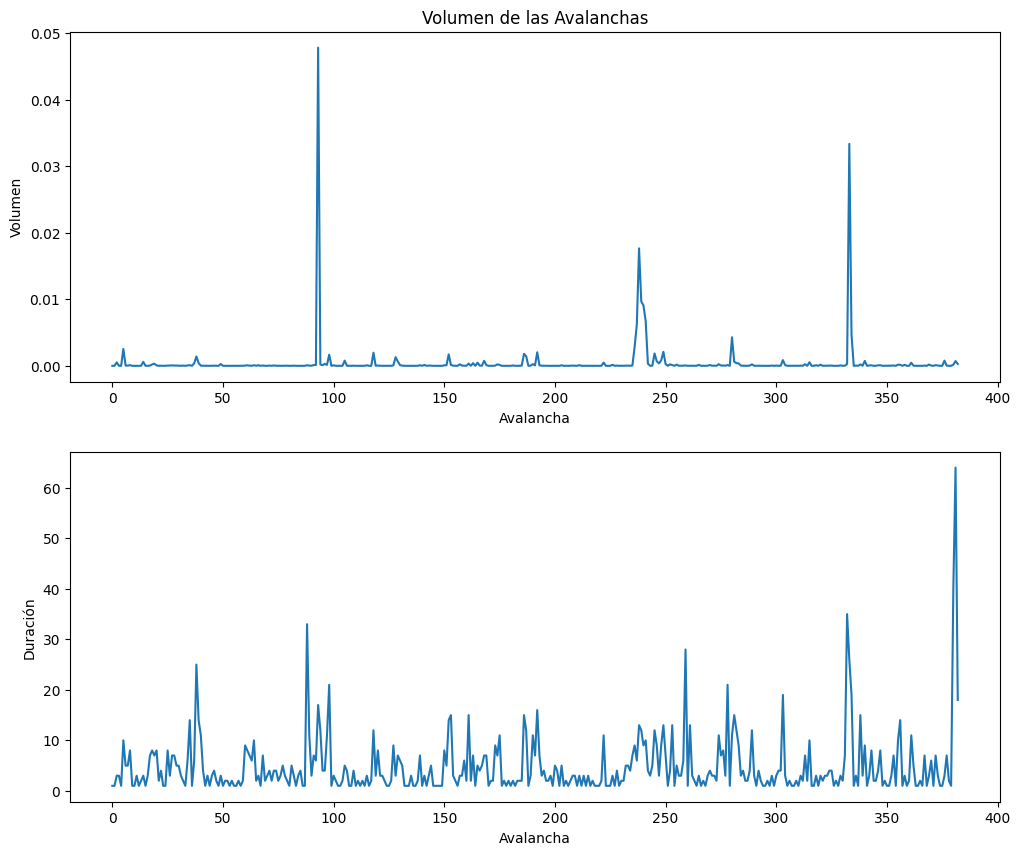

In [92]:
# Ploteo los volúmenes y duraciones
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(volumenes)
ax1.set_xlabel('Avalancha')
ax1.set_ylabel('Volumen')
ax1.set_title('Volumen de las Avalanchas')
# ax1.set_yscale('log')

ax2.plot(duraciones)
ax2.set_xlabel('Avalancha')
ax2.set_ylabel('Duración')

plt.show()

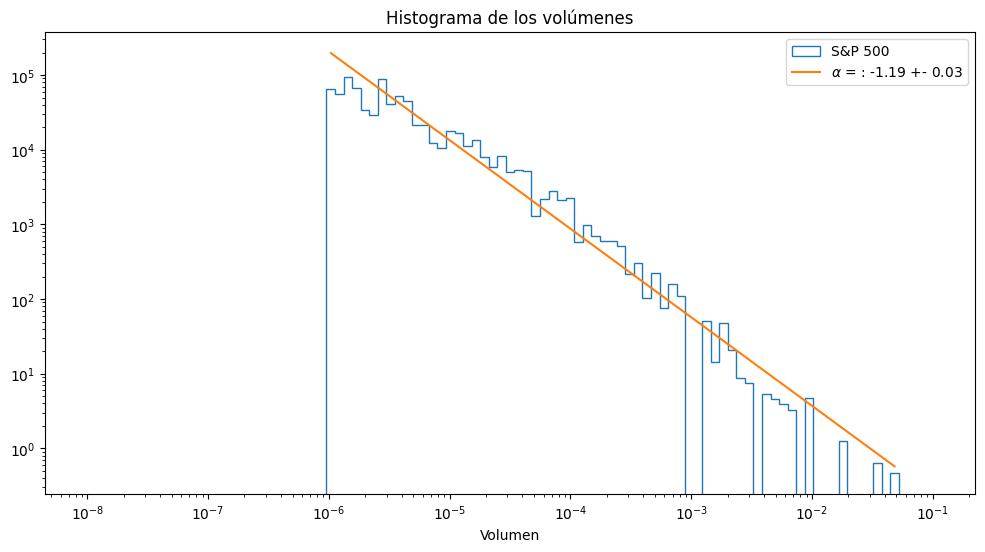

In [93]:
nbins = 100
bins = np.logspace(-8, -1, nbins)
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(volumenes, bins=bins, density=True, histtype='step', label="S&P 500")

x = (bins[:-1] + bins[1:]) / 2

# Ajusto una distribución de potencia
start = 15
end = nbins - 1

x_fit = x[start:end]
y_fit = counts[start:end]

x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=r'${\alpha}$ = 'f': {-alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Volumen")
plt.title("Histograma de los volúmenes")

plt.show()

El coeficiente me da $1.19$, bastante diferente al paper de Bertolozzi (le da 1.7 a 1.9 con distintos cutoffs en la Fig. 8). Yo creo que las diferencias se deben a que sus datos son de mayor frecuencia (minutos) y los mios son diarios. En este caso, hay muchos eventos de avalanchas de menor tamaño que no se pueden ver en mis datos. De todas formas, el histograma muestra que hay avalanchas de distintos tamaños, y que no son eventos raros, por lo que tenemos criticalidad.

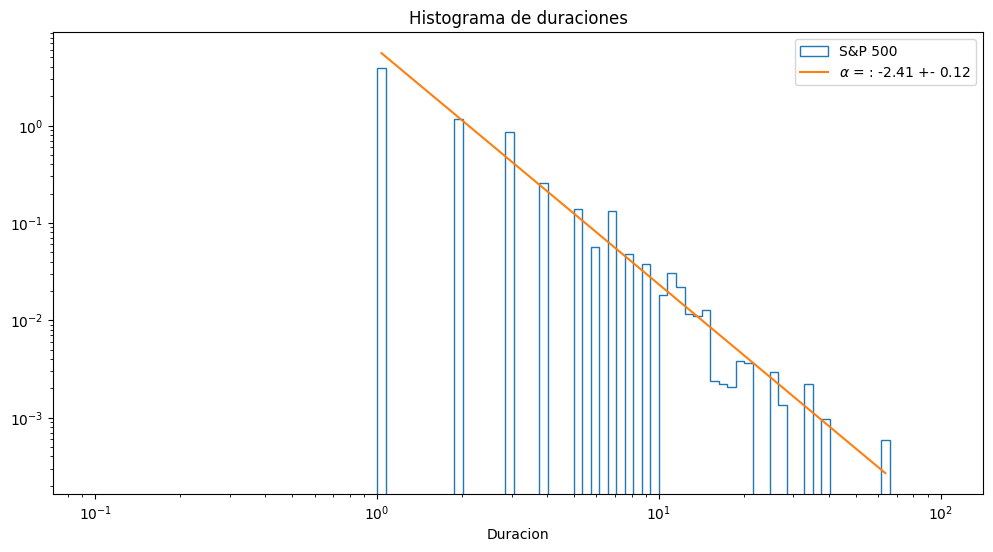

In [94]:
nbins = 100
bins = np.logspace(-1, 2, nbins)
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(duraciones, bins=bins, density=True, histtype='step', label="S&P 500")

x = (bins[:-1] + bins[1:]) / 2

# Ajusto una distribución de potencia
start = 15
end = nbins - 1

x_fit = x[start:end]
y_fit = counts[start:end]

x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=r'${\alpha}$ = 'f': {-alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Duracion")
plt.title("Histograma de duraciones")

plt.show()

Con las duraciones si tengo un valor coherente con el de Bartolozzi (Le da de 2.3 a 2.7 en la Fig.9 para distintos cutoffs), igualmente hay muy pocos datos en este caso.  

### Conclusión
- Parece haber criticalidad en el precio del S&P500, aunque el coeficiente da distinto al del paper analizado, que puede llegar a deberse a la resolución temporal de mi serie.
- El método de wavelet es útil para detectar avalanchas y eliminar el ruido de estas series temporales.

- Podemos encontrar un análogo entre las condiciones de criticalidad que enumera el chule y mi sistema? Lo voy a intentar. Recordemos que las condiciones (supuestamente suficientes) para la criticalidad son:

    1. Sistema abierto y disipativo.
    2. Sujeto a un forzado lento.
    3. Sujeto a una inestabilidad localizada.
    4. Capaz de reacomodarse para restaurar el equilibrio.

    Vagamente se puede decir que:

    1. El sistema es abierto porque hay una cantidad de agentes que pueden comprar o vender el activo, y disipativo porque hay fricción en el mercado (comisiones, impuestos, etc).
    2. El forzado lento puede ser la tendencia de largo plazo del precio, que hace que muchos inversores vayan entrando al mercado y acumulando órdenes de compra (salvo cuando hay eventos tipo avalancha y la tendencia suele revertirse).
    3. La inestabilidad localizada puede deberse a grandes capitales capaces de mover el precio de un activo, o a eventos inesperados que generan avalanchas (noticias externas o cambios en regulaciones, etc.), pero no veo bien la parte "localizada" en esto, sino parece algo más bien global.
    4. El sistema se reacomoda para restaurar el equilibrio cuando hay avalanchas, y el precio vuelve a un valor de equilibrio que suele ser diferente al anterior.

YAPA: Qué pasa con el bitcoin? Hay criticalidad?

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Precio (USD)')

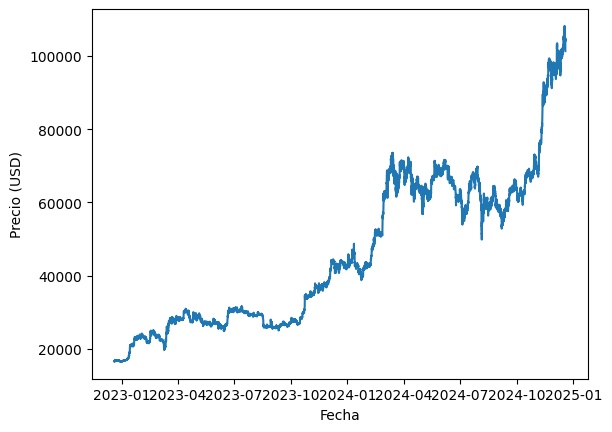

In [95]:
btc = yf.download("BTC-USD", start=None, end=None, interval="1h")

plt.plot(btc['Adj Close'])
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")

In [96]:
btc['Log Return'] = np.log(btc['Adj Close'] / btc['Adj Close'].shift(1))
btc.dropna(inplace=True)

Curtosis de la serie filtrada: 60.20659394941836
Asimetría de la serie filtrada: -0.48290082862046607
Curtosis del ruido: 2.010774763529871
Asimetría del ruido: 0.018841232774145254


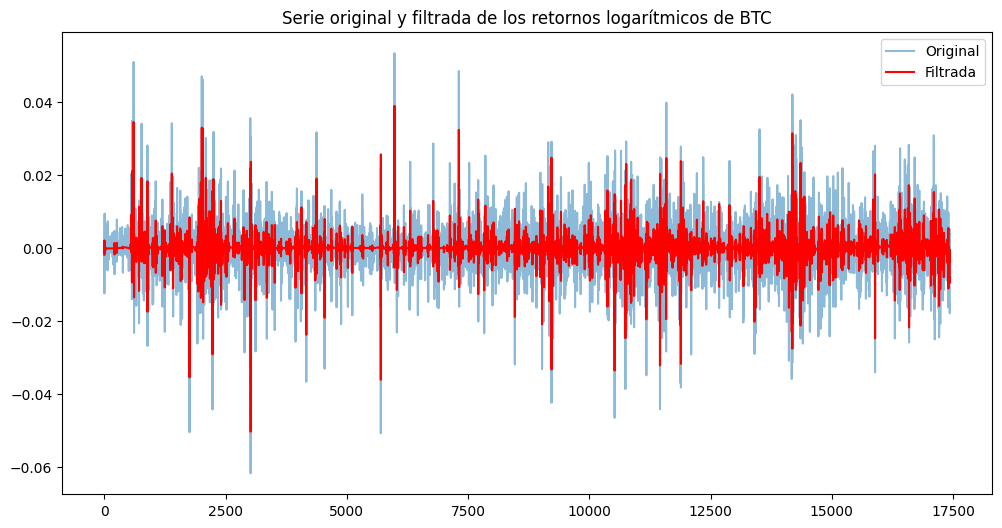

In [99]:
# Supón que 'log_returns' es tu serie temporal de retornos logarítmicos
log_returns = btc['Log Return'].values

# Realiza la descomposición wavelet con la wavelet Daubechies de orden 4
wavelet = 'db4'
coeffs = pywt.wavedec(log_returns, wavelet)

# Filtra los coeficientes eliminando los de baja energía
cutoff = .12
threshold = cutoff * np.max(coeffs[-1])  # Ajusta este umbral según sea necesario
filtered_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Reconstruye la serie temporal filtrada
filtered_log_returns = pywt.waverec(filtered_coeffs, wavelet)
noise_signal = log_returns - filtered_log_returns[:len(log_returns)]

# La curtosis me da una idea de la cantidad de outliers que hay en la serie
# La asimetría me da una idea de si hay una tendencia en la serie
# Quiero ajustar el valor de cutoff para que el ruido que voy a filtrar tenga
# una curtosis y asimetría más parecidas a las de una gaussiana
print("Curtosis de la serie filtrada:", stats.kurtosis(filtered_log_returns))
print("Asimetría de la serie filtrada:", stats.skew(filtered_log_returns))
print("Curtosis del ruido:", stats.kurtosis(noise_signal))
print("Asimetría del ruido:", stats.skew(noise_signal))

# Graficar la serie original y la filtrada
plt.figure(figsize=(12, 6))
plt.plot(log_returns, label='Original', alpha=0.5)
plt.plot(filtered_log_returns, label='Filtrada', color='red')
plt.title("Serie original y filtrada de los retornos logarítmicos de BTC")
plt.legend()
plt.show()

In [103]:
epsilon = 0.001  # Ajusta este valor según sea necesario
indices_avalanchas = np.where(np.abs(filtered_log_returns) > epsilon)[0]

# Identificar periodos de avalanchas (donde los índices están contiguos)
avalanchas = []
inicio = indices_avalanchas[0]
for i in range(1, len(indices_avalanchas)):
    if indices_avalanchas[i] != indices_avalanchas[i - 1] + 1:
        avalanchas.append((inicio, indices_avalanchas[i - 1]))
        inicio = indices_avalanchas[i]
avalanchas.append((inicio, indices_avalanchas[-1]))  # Agregar la última avalancha


# Los volumenes se definen como la suma de los retornos al cuadrado
volumenes = []
for inicio, fin in avalanchas:
    volumen = np.sum(filtered_log_returns[inicio:fin]**2)
    volumenes.append(volumen)

duraciones = [fin - inicio + 1 for inicio, fin in avalanchas]
tiempos_entre_avalanchas = tiempos_espera = [avalanchas[i + 1][0] - avalanchas[i][1] for i in range(len(avalanchas) - 1)]

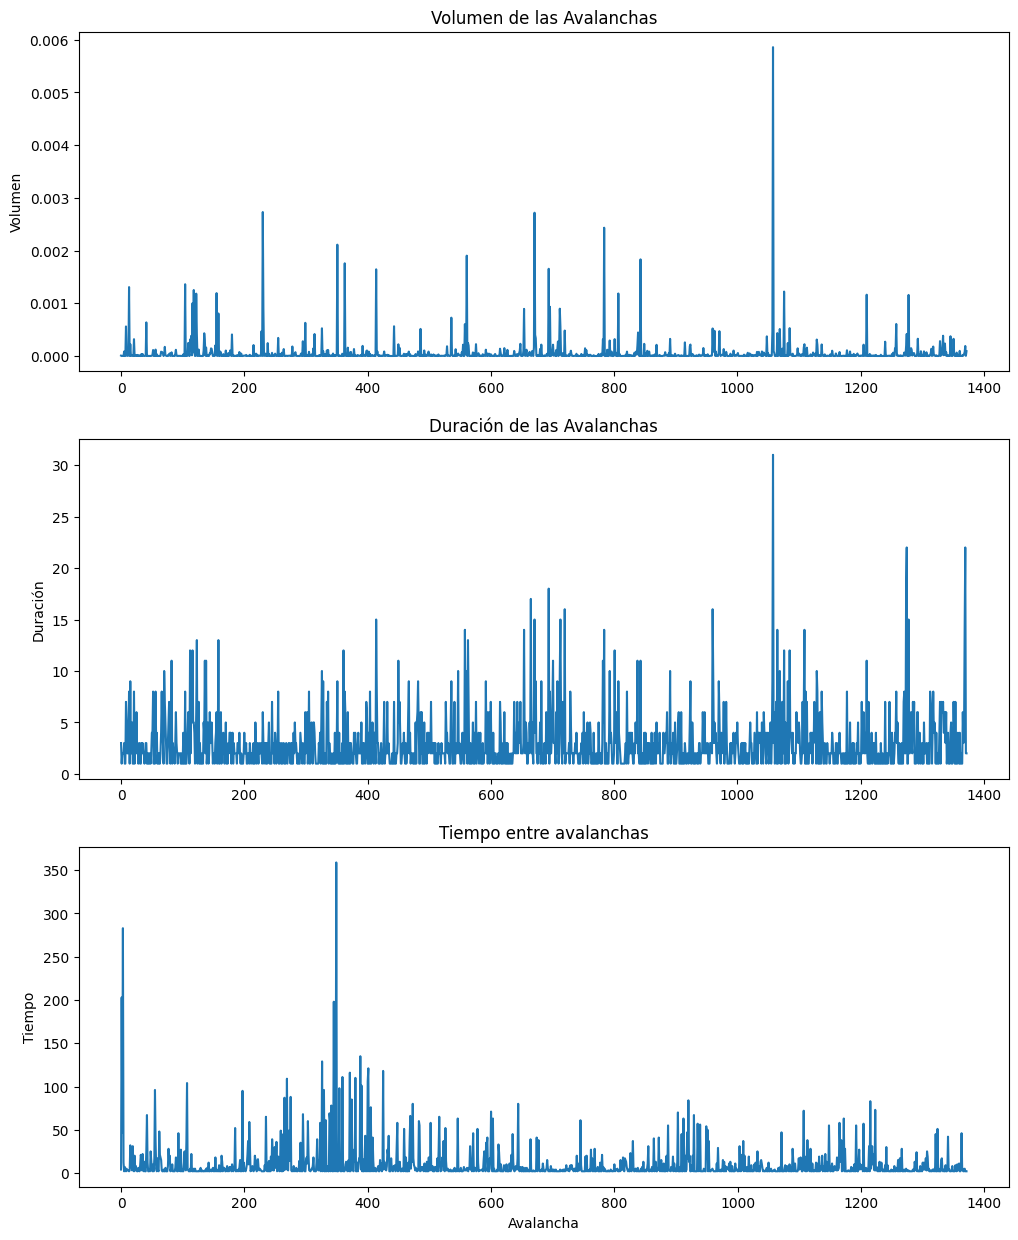

<Figure size 640x480 with 0 Axes>

In [104]:
# Ploteo los volúmenes y duraciones
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

ax1.plot(volumenes)
ax1.set_ylabel('Volumen')
ax1.set_title('Volumen de las Avalanchas')

ax2.plot(duraciones)
ax2.set_ylabel('Duración')
ax2.set_title('Duración de las Avalanchas')

ax3.plot(tiempos_entre_avalanchas)
ax3.set_xlabel('Avalancha')
ax3.set_ylabel('Tiempo')
ax3.set_title('Tiempo entre avalanchas')

plt.show()
plt.tight_layout()

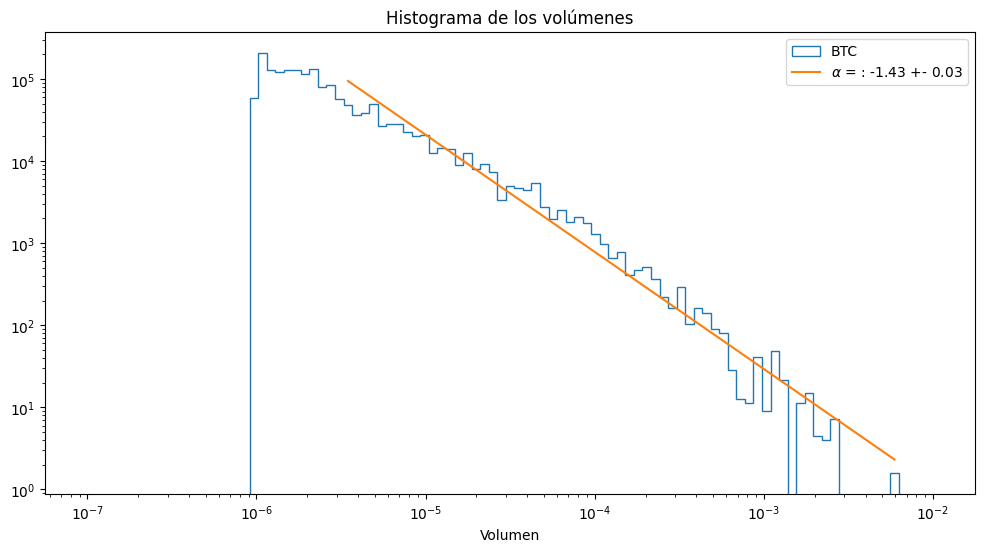

In [106]:
bins = np.logspace(-7, -2, 100)
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(volumenes, bins=bins, density=True, histtype='step', label="BTC")

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 30
end = 100

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=r'${\alpha}$ = 'f': {-alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.legend()


plt.xscale("log")
plt.yscale("log")

plt.xlabel("Volumen")
plt.title("Histograma de los volúmenes")

plt.show()

Acá si podemos hacer un histograma de las duraciones

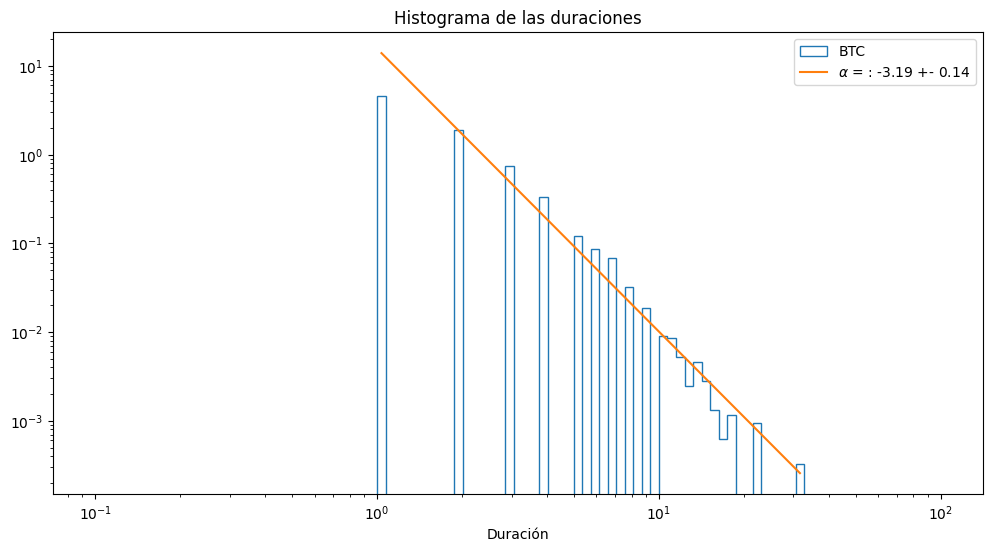

In [108]:
bins = np.logspace(-1, 2, 100)
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(duraciones, bins=bins, density=True, histtype='step', label="BTC")

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 0
end = 100

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=r'${\alpha}$ = 'f': {-alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.legend()


plt.xscale("log")
plt.yscale("log")

plt.xlabel("Duración")
plt.title("Histograma de las duraciones")

plt.show()

Vemos comportamiento crítico en el primer histograma, para el segundo faltaría más resolución. Qué pasa con el tiempo entre avalanchas?

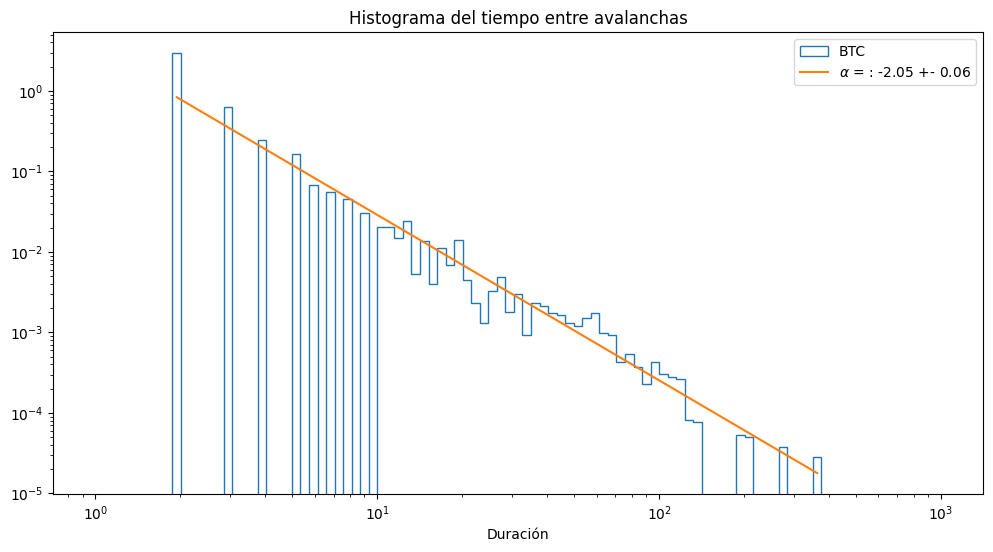

In [109]:
bins = np.logspace(0, 3, 100)
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(tiempos_entre_avalanchas, bins=bins, density=True, histtype='step', label="BTC")

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 0
end = 100

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=r'${\alpha}$ = 'f': {-alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.legend()


plt.xscale("log")
plt.yscale("log")

plt.xlabel("Duración")
plt.title("Histograma del tiempo entre avalanchas")

plt.show()

Boffetta (1999) - Power Laws in Solar Flares: Self-Organized Criticality or Turbulence?

![Boffetta (1999) - Power Laws in Solar Flares: Self-Organized Criticality or Turbulence? ](nearsoc.png)